In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Домашка №1

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Некоторые магические трансформации, о которых пока не стоит заморачиваться
1. Перевод картинки в тензор
1. Нормализация картинки

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

## Переводим его в два класса

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7  

Выбрал эти цифры, потому что на них хуже всего метрики

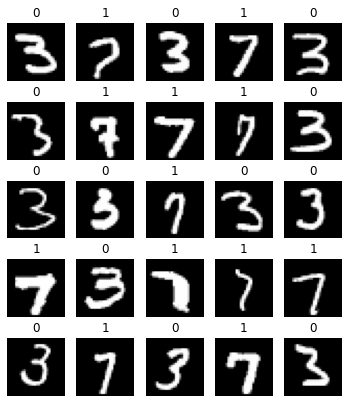

In [6]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Итерация по датасету
- x - батч с данными
- y - батч с таргетами к этим данным

In [7]:
for x, y in train_loader:
    break

### train_loader это итератор, при проходе по которому будут выдаваться батчи данных

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [16]:
x.shape

torch.Size([128, 1, 28, 28])

In [17]:
x

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Просто выпрямим нашу матрицу в один вектор
### То есть каждая фича в векторе это значение пикселя
### Для нашей игрушечной задачи этого будет достаточно

In [18]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

### x.numpy()
Это перевод торчового тензора (некоторая абстракция, о которой мы будем говорить позже на курсе) в numpy массив

In [21]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [22]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [23]:
x.shape

(128, 784)

# Таргеты
- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7

In [24]:
y

array([0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0])

# Итерация по эпохам

In [25]:
# количество эпох - полных проходов по датасету
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными
        # например, учить, но пока этого делать не будет
        # только демонстрация
        
        time.sleep(0.05)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Небольшие пояснения по numpy

In [131]:
# таким образом мы создаем матрицу 64 на 512 с рандомными значениями
x = np.random.rand(64, 512)
x

In [134]:
# большинство функций применяются к каждому элементу массива
# здесь мы каждый элемент массива возвели в квадрат и прибавили к получившемуся значению логарифм элемента матрицы 
x ** 2 + np.log(x)

array([[ 0.49311628, -2.09519724, -0.71027635, ...,  0.89869507,
        -0.98060862,  0.18476493],
       [-0.31857181,  0.7098281 , -0.33204611, ...,  0.58021141,
        -4.90216295, -2.28819643],
       [-0.78353286, -1.23833097, -1.9838382 , ...,  0.85144047,
        -0.38260977, -1.38641475],
       ...,
       [ 0.51152187,  0.97175232, -2.08929339, ..., -2.02438163,
        -1.46950128, -0.75260723],
       [-0.97474378,  0.94380748,  0.55066923, ...,  0.54216404,
         0.26676935, -2.28097525],
       [-0.70220662,  0.24304389, -0.18361048, ..., -0.06727845,
        -1.24796688, -0.74534121]])

In [137]:
y = np.random.rand(512, 1024)
# скалярное произведение
res = np.dot(x, y)

In [138]:
res

array([[131.10694652, 124.54527032, 126.38507165, ..., 122.56950129,
        130.42206636, 124.41662942],
       [132.97426799, 130.19808924, 130.74234643, ..., 126.93665834,
        134.8023778 , 127.85610576],
       [127.46004068, 130.87503051, 125.46921229, ..., 122.53419404,
        127.01669733, 123.79929117],
       ...,
       [127.72833098, 126.20468035, 127.87172453, ..., 122.13812367,
        126.72210024, 121.9661366 ],
       [138.01213608, 136.37581658, 132.25130421, ..., 130.25274969,
        135.00184643, 131.36667546],
       [133.40891018, 135.75703121, 131.4610805 , ..., 129.42051987,
        135.15551476, 129.3233544 ]])

In [140]:
res.shape == (x.shape[0], y.shape[1])

True

### Производные линейного слоя
Мы знаем, что нам нужно будет по градиентам весов обновить эти веса. То есть это просто смещение наших весов на какой-то шаг. Отсюда следует, что размерность весов и градиента к ним должна совпадать. Используйте для этого скалярное произведение, траснпонирование и предыдущий градиент.  
То есть размерность какого-либо параметра должна совпадать с размерностью градиента к этому параметру. В случае с параметров b мы помним, что это смещение и по сути это добавление к нашим входным фичам фичи с единичным значением.

```python
grad_w = np.dot(x.T, grad_prev)
grad_x = np.dot(grad_prev, w.T)
grad_b = np.dot(np.ones((x.shape[0])), grad_prev)
```

Более подробный совет:  
Tip: use dimension analysis! Note that you do not need to remember the expressions for dW and dX because they are easy to re-derive based on dimensions. For instance, we know that the gradient on the weights dW must be of the same size as W after it is computed, and that it must depend on matrix multiplication of X and dD (as is the case when both X,W are single numbers and not matrices). There is always exactly one way of achieving this so that the dimensions work out. For example, X is of size [10 x 3] and dD of size [5 x 3], so if we want dW and W has shape [5 x 10], then the only way of achieving this is with np.dot(dD, X.T), as shown above.  
[Источник](https://cs231n.github.io/optimization-2/)

Полезные видео:  
- [Один](https://www.coursera.org/lecture/intro-to-deep-learning/multilayer-perceptron-mlp-yy1NV)
- [Два](https://www.coursera.org/lecture/intro-to-deep-learning/chain-rule-rK0tw)
- [Три](https://www.coursera.org/lecture/intro-to-deep-learning/backpropagation-CxUe5)
- [Четыре](https://www.coursera.org/lecture/intro-to-deep-learning/efficient-mlp-implementation-P3VH6)
- [Пять](https://www.coursera.org/lecture/intro-to-deep-learning/other-matrix-derivatives-YTunl)

# Задание

### Шаги:
1. Задайте обучаемые параметры (TIP: np.random.rand)
1. Задайте скорость обучения (подойдет 0.01, но можете попробовать другие и посмотреть что меняется), количество эпох (полных проходов по датасету)
1. Сделайте линейную трансформацию через первый слой (первый набор весов)
1. Примените какую-нибудь нелийную функцию активации (tanh, relu)
1. Сделайте линейную трансформацию через второй слой (второй набор весов)
1. Примените сигмоиду
1. Рассчитайте функцию потерь (бинарная кросс энтропия), не забудьте усреднить по батчу
1. Сохраняйте значения функции потерь в массив losses
1. Возьмите производные от функции потерь к каждому обучаемому параметру [видео про производные](https://youtu.be/tZ0yCzWfbZc)
1. Обновите веса w1, b1, w2, b2 с помощью градиентного спуска
1. Нарисуйте график функции потерь

- TIP: количество входных фичей - 784 (28 пикселей * 28 пикселей)
- TIP: в шаге 0 домножьте w1, w2 на 0.01, а b1, b2 инициализируйте нулями. Это не самая лучшая реализация, но пока лучше мы не знаем
- TIP: в backward функции потерь по предсказаниям вашей модели нужно разделить еще на количество примеров в батче (не забудьте, что усредняете лосс)
- TIP: каждый следующий градиент рассчитывайте умножая на предыдущий, то есть не нужно расчитывать по каждому слою и затем все мерджить. Нужно сразу для d_L/d_z2 считать градиент как d_L/d_y_hat умноженный на d_y_hat/d_z2, где y_hat это наши предсказания.

## Если вам сложно, сделайте сначала для одного слоя

In [27]:
### КОД СЮДА ###

learning_rate = 0.1
epochs = 10
b1 = np.zeros((5,))
w1 = np.random.rand(784, 5) * 0.01
b2 = np.zeros((1,))
w2 = np.random.rand(5, 1) * 0.01

losses = []

for n_epoch in range(epochs):
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
        
        z1 = np.dot(x, w1) + b1
        a1 = (np.exp(z1) - np.exp(-(z1)))/(np.exp(z1) + np.exp(-(z1))) 
        z2 = np.dot(a1, w2) + b2
        pred = 1/(1 + np.exp(-z2))

        loss = -((y * np.log(pred) + (1-y) * np.log(1-pred))).mean()
        losses.append(loss)
        
        
        dL_dpred = ((1-y)/(1-pred)-(y/pred))/x.shape[0]
        dL_dz2 = dL_dpred * pred * (1-pred)
        dL_da1 = dL_dz2.dot(w2.T)
        dL_dz1 = dL_da1 * (1 - a1**2)
        dL_dw2 = np.dot(a1.T, dL_dz2)
#         dL_db2 = dL_dz2.mean()
        dL_db2 = np.dot(np.ones((1,x.shape[0])), dL_dz2) 
        dL_dw1 = np.dot(x.T, dL_dz1) 
        dL_db1 = np.dot(np.ones((1, x.shape[0])), dL_dz1)
#         dL_db1 = dL_dz1.mean()


        w1 = w1 - learning_rate * dL_dw1 
        w2 = w2 - learning_rate * dL_dw2
        b1 = b1 - learning_rate * dL_db1
        b2 = b2 - learning_rate * dL_db2

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


## Подсказки по размерностям

### Forward

- z1 - первое линейное преобразование - (BATCH_SIZE, INNER_FEATURES)
- a1 - Применение нелинейности - (BATCH_SIZE, INNER_FEATURES)
- z2 - второе нелинейное преобразование - (BATCH_SIZE, 1)
- pred - сигмоида - (BATCH_SIZE, 1)
- loss - функция потерь - скаляр

### Backward

- d_loss/d_pred - градиент функции потерь по pred - (BATCH_SIZE, 1)
- d_loss/dz2 - градиент сигмоиды по z2 - (BATCH_SIZE, 1)
- d_loss/da1 - градиент линейного преобразования по a1 - (BATCH_SIZE, INNER_FEATURES)
- d_loss/dw2 - градиент линейного преобразования по w2 - (INNER_FEATURES, 1)
- d_loss/db2 - градиент линейного преобразования по b2 - (1,)
- d_loss/dz1 - градиент нелинейной функции по z1 - (BATCH_SIZE, INNER_FEATURES)
- d_loss/dw1 - градиент линейного преобразования по w1 - (IN_FEATURES, INNER_FEATURES)
- d_loss/db1 - градиент линейного преобразования по b1 - (INNER_FEATURES,)

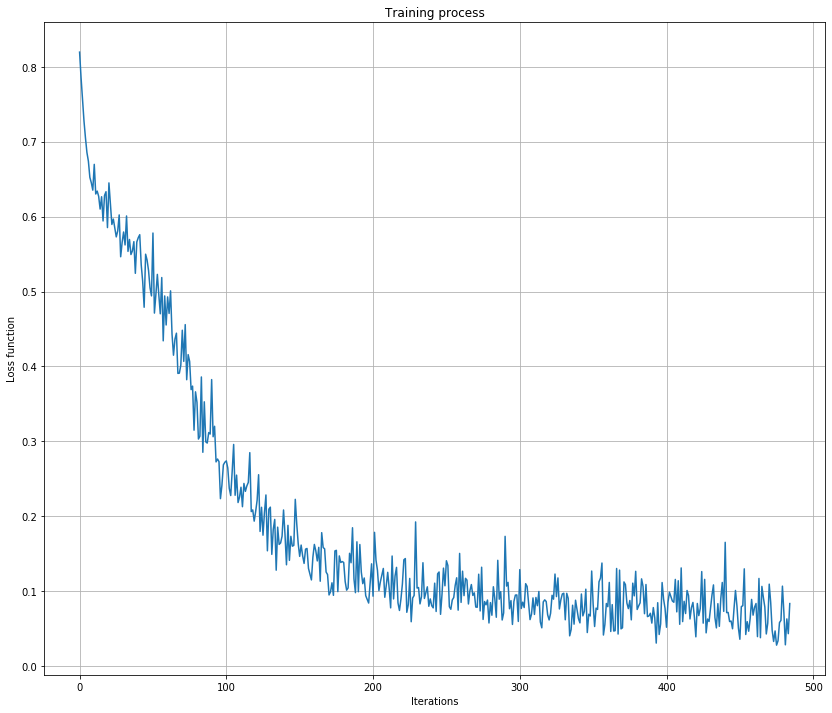

In [107]:
#было
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

Text(0, 0.5, 'Loss function')

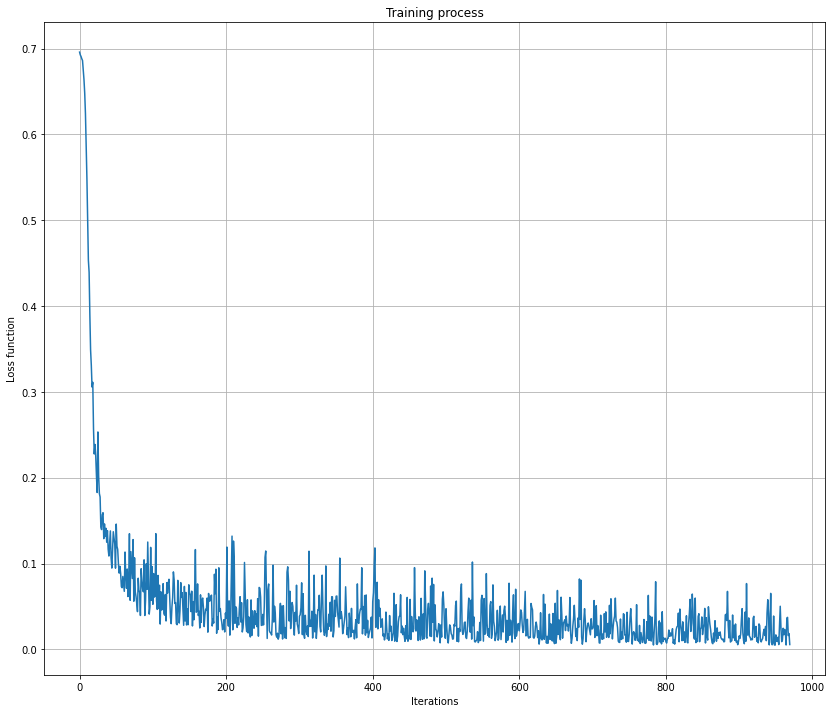

In [28]:
#стало для np.ones
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

In [29]:
np.mean(losses)

0.04928222179177012

Text(0, 0.5, 'Loss function')

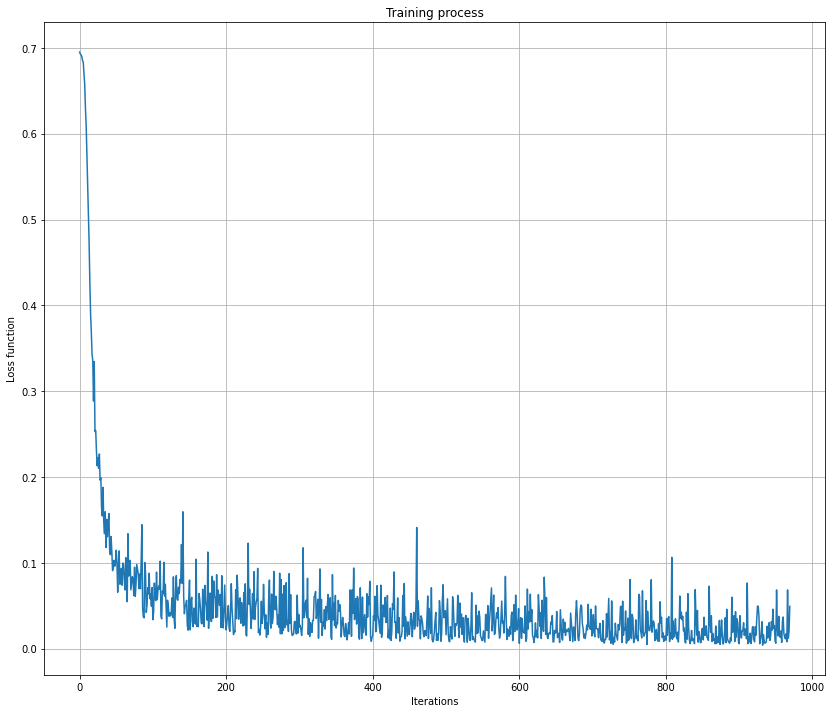

In [25]:
#стало для mean()
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

In [26]:
np.mean(losses)

0.05026509142290399

# Нужно получить значение лосса ниже 0.1 (на графике)
```np.mean(losses)``` примерно должно равняться 0.15  
Это где-то 0.9+ accuracy

# На данном моменте домашка заканчивается
### Если вы хотите сделать более продвинутую версию, то ниже есть все необходимое. В курсе оцениваться никак не будет. Только для большего понимания устройства deep learning фреймворков

# В любом случае стоит посмотреть [введение в torch](#Введение-в-torch)
Вам это понадобится дальше

# Импортируем нашу библиотеку

## Реализуйте такие слои:
- Linear - линейная трансформация (не забудьте, что у нас там как раз есть обучаемые параметры)
- ReLU
- BCELoss - Binary Cross Entropy


## Вы можете реализовать как здесь, так и в файла layers

- TIP: np.expand_dims(y, 1) для BCE, так как BCE на вход принимает просто вектор размерностью (батч сайз, )

## Также внутри layers есть код для Negative Log-Likelihood (сразу с софтмаксом)

In [23]:
from our_library import layers, wrapper, tools

# Пример

In [109]:
class Sigmoid:

    def __init__(self):

        self._sigmoid_result = None

    def forward(self, x):

        self._sigmoid_result = 1 / (1 + np.exp(-x))

        return self._sigmoid_result

    def backward(self, grad):
        """
        :grad: градиент от предыдущего слоя
        :return: градиент для следующего слоя
        """

        new_grad = self._sigmoid_result * (1 - self._sigmoid_result) * grad

        return new_grad

    def step(self, learning_step):

        pass

# Пример работы тестов

In [110]:
x = np.array([[0.91551091, 0.15073826, 0.77137556, 0.59352491],
              [0.81126142, 0.1194849 , 0.29651178, 0.19066982]])

In [111]:
sigmoid_layer = Sigmoid()

In [112]:
forward_result = sigmoid_layer.forward(x)

In [113]:
correct_forward_result = np.array([[0.71412654, 0.53761337, 0.68381838, 0.64417351],
                                   [0.69237824, 0.52983574, 0.57358957, 0.54752357]])

In [126]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward_result)

In [127]:
backward_result = sigmoid_layer.backward(np.ones_like(x))

In [128]:
correct_backward_result = np.array([[0.20414982, 0.24858523, 0.2162108 , 0.229214  ],
                                    [0.21299061, 0.24910983, 0.24458457, 0.24774151]])

In [129]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward_result)

## Template

In [68]:
class ReLU:

    def __init__(self):
        
        pass

    def forward(self, x):

        pass

    def backward(self, grad):

        pass

    def step(self, learning_rate):

        pass

In [33]:
from our_library_solved.layers import Linear, ReLU, BCELoss

In [33]:
class Linear:

    def __init__(self, in_features, out_features):
        
        # инициализируем веса
        self.weight = 
        self.bias = 
        
        # сохраняем градиент для весов
        self._grad_weight = None
        self._grad_bias = None

    def forward(self, x):

        pass

    def backward(self, grad):

        pass

    def step(self, learning_rate):

        pass

SyntaxError: invalid syntax (<ipython-input-33-7b91485e7beb>, line 5)

# Linear test

In [34]:
linear = Linear(in_features=4, out_features=3)

In [35]:
# так как внутри слоя мы объвяляем наши веса рандомно (домножая на 0.01), то давайте присвоим им для теста конкретные значения

linear.weight = np.array([[0.00879391, 0.0075844 , 0.00430709],
                          [0.00884834, 0.00921104, 0.00044317],
                          [0.00011441, 0.00822498, 0.00122346],
                          [0.00338301, 0.0001627 , 0.00711473]])

linear.bias = np.array([0., 0., 0.])

In [36]:
correct_forward_result = np.array([[0.01148086, 0.01477317, 0.00917651],
                                   [0.00887036, 0.00972334, 0.00526646]])

In [37]:
forward = linear.forward(x)

In [38]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

-1.2008401972449234e-09

In [39]:
previous_grad = np.array([[0.01595814, 0.85148336, 0.9980065 ],
                          [0.73044998, 0.18287682, 0.41246361]])

In [40]:
correct_backward_result = np.array([[0.01089683, 0.00842654, 0.00822628, 0.00729307],
                                    [0.00958704, 0.00833055, 0.00209236, 0.00543544]])

In [41]:
backward = linear.backward(previous_grad)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

In [43]:
correct_grad_weight = np.array([[0.60719574, 0.92790321, 1.24830165],
                                [0.08968325, 0.15020214, 0.19972094],
                                [0.22889674, 0.71103859, 0.89213814],
                                [0.14874632, 0.54024567, 0.67098608]])

In [ ]:
# значения должны быть близкими
assert np.allclose(linear._grad_weight, correct_grad_weight)

In [45]:
correct_grad_bias = np.array([0.74640812, 1.03436018, 1.41047011])

In [ ]:
# значения должны быть близкими
assert np.allclose(linear._grad_bias, correct_grad_bias)

# ReLU test

In [47]:
relu = ReLU()

In [48]:
x = np.array([[ 0.86811233, -0.23718669, -0.18401917, -0.37591633],
              [-0.40626018,  0.37746975, -0.46929233,  0.79067681]])

In [49]:
forward = relu.forward(x)

In [50]:
correct_forward_result = np.array([[0.86811233, 0.        , 0.        , 0.        ],
                                   [0.        , 0.37746975, 0.        , 0.79067681]])

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [52]:
previous_grad = np.array([[0.22436157, 0.61897707, 0.67895832, 0.72428618],
                          [0.71231319, 0.87345215, 0.91129578, 0.90625846]])

In [53]:
correct_backward_result = np.array([[0.22436157, 0.        , 0.        , 0.        ],
                                    [0.        , 0.87345215, 0.        , 0.90625846]])

In [54]:
backward = relu.backward(previous_grad)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

# BCE test

### Не забудьте добавить np.expand_dims(y, 1) в forward
```python
class BCELoss:

    def __init__(self):
        
        pass

    def forward(self, x, y):

        y = np.expand_dims(y, 1)

    def backward(self):
        pass

    def step(self, learning_rate):
        pass
```

In [56]:
loss = BCELoss()

In [57]:
x = np.array([[0.76242307],
              [0.0908412 ],
              [0.60176646],
              [0.09606798]])

y = np.array([1, 0, 1, 0])

In [58]:
forward = loss.forward(x, y)

In [59]:
correct_forward_result = 0.24384403491500606

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [61]:
backward = loss.backward()

In [62]:
correct_backward_result = np.array([[-0.32790194],
                                    [ 0.27497946],
                                    [-0.41544356],
                                    [ 0.27656947]])

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

## Реализуйте обертку над слоями - нейронную сеть
- TIP 1: modules - это список слоев, которые вы сделали выше. Порядок важен
- TIP 2: циклы это круто
- TIP 3: forward идет в одну сторону по слоям, а backward в другую
- TIP 4: В backward функции потерь мы не передаем предыдущий градиент, потому что это начало backward
- TIP 5: forward и backward ничего не должны отдавать
- TIP 6: в step нужно пройтись по всем слоям и обновить веса

In [64]:
class NeuralNetwork:

    def __init__(self, modules):

        # список слоев
        self.modules = modules

    def forward(self, x):

        pass

    def backward(self, grad):
        """
        :grad: градиент от функции потерь
        :return: возвращать ничего не потребуется
        """

        pass

    def step(self, learning_rate):

        pass

## Реализуйте обертку над моделью

In [66]:
class MNISTWrapper(wrapper.Wrapper):

    def __init__(self, model, loss, learning_rate=0.001, multi_class=False):

        # передаем параметры, чтобы отработал __init__ от наследуемого класса
        # можно было бы сделать через **kwargs, но сделал так для наглядности и чтобы были подсказки в юпитере

        super().__init__(model=model, loss=loss, learning_rate=learning_rate, multi_class=multi_class)

    def train_batch(self, x, y):
        """
        Нужно реализовать одну итерацию обучения модели:
        1. Рассчет forward
        2. Рассчет функции потерь
        3. Рассчет backward от функции потерь
        4. Рассчет backward по модели, передавая туда значение градиента по функции потерь
        5. Обновление весов с помощью step
        :param x: входные данные np.array with shape (batch_size, n_features)
        :param y: предсказания np.array with shape (batch_size, n_classes)
        :return:
        loss_batch - значение функции потерь, просто скаляр
        prediction - матрица предсказаний вашей модели

        напомню важные штуки, которые знает наш класс:
        self.model
        self.loss
        self.learning_rate
        """

    def predict_batch(self, x):
        """
        Предсказание (aka inference) вашей модели:
        1. Рассчет forward
        :param x: входные данные np.array with shape (batch_size, n_features)
        :return: prediction - матрица предсказаний вашей модели
        """
        
        # Больше ничего делать не нужно
        # Все уже сделано
        
        return self.model.forward(x)

In [ ]:
# задайте гиперпараметры
learning_rate = ...
epochs = ...

# задайте слои в свою нейронную сеть, например, 3 слоя
neural_network = layers.NeuralNetwork(...)

loss = layers.BCELoss()

In [34]:
classifier = MNISTWrapper(model=neural_network,
                          loss=loss,
                          learning_rate=learning_rate)

## Раскомментируйте и запустите

In [67]:
classifier.train(train_loader, test_loader, epochs=epochs)

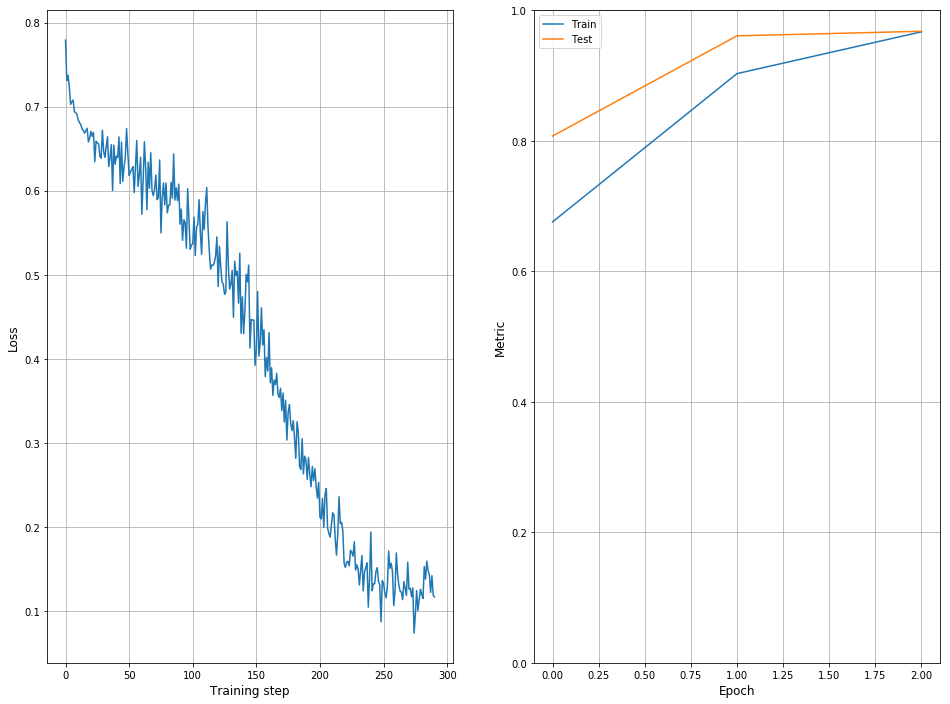

In [135]:
classifier.plot()

# Введение в torch

In [68]:
import torch

### Мы можем определить нашу модель как последовательность уже существующих слоев, как в керасе

In [69]:
model = torch.nn.Sequential()

model.add_module(name='linear_1', module=torch.nn.Linear(in_features=784, out_features=256))
model.add_module(name='relu', module=torch.nn.ReLU())
model.add_module(name='linear_2', module=torch.nn.Linear(in_features=256, out_features=1))
model.add_module(name='sigmoid', module=torch.nn.Sigmoid())

model

Sequential(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Либо так

In [70]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=784, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=256, out_features=1),
    torch.nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1, bias=True)
  (3): Sigmoid()
)

## А вот для чего нужно было писать в домашке классы
## Для определения своих моделей/слоев/чего вам захочется нам нужно сделать такую структуру

In [71]:
# наследуемся от класса torch.nn.Module
class MLP(torch.nn.Module):
    
    # определяем метод __init__
    # он нужен для того, чтобы мы могли определить нужные нам слои, веса, сохраняемые операции
    # 
    # передаем ссылку на самого себя первым параметром
    # 
    # определяем любые другие передаваемые аргументы
    # могут быть чем угодно: числа, словари, другие слои, другие модели и вообще все что угодно
    # 
    def __init__(self, in_features, inner_features, out_features):
        
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        # определяем слои и все что захотим сохранять/использовать
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
        self.non_linear_function = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=out_features)
        self.sigmoid = torch.nn.Sigmoid()
        
    # нам нужно обязательно реализовать метод forward
    # это то, что нашей модели нужно делать, как оперировать с входными данными, как рассчитывать
    # метод backward нам не нужно реализовывать, потому что в торче есть автоматическое дифференцирование
    # главное, чтобы наши операции были дифференцируемы
    # некоторые подробности можете узнать здесь:
    # https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py
    # также список доступных дифференцируемых операций можете посмотреть здесь:
    # https://pytorch.org/docs/stable/tensors.html
    def forward(self, x):
        
        # наша привычная схема
        x = self.linear_1(x)
        x = self.non_linear_function(x)
        x = self.linear_2(x)
        x = self.sigmoid(x)
        
        return x
    
    # мы также можем реализовать любые другие полезные нам методы внутри класса

In [72]:
# определяем нашу модель
model = MLP(in_features=784, inner_features=256, out_features=1)

In [73]:
model

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [74]:
# можем посмотреть веса
model.linear_1.weight.shape

torch.Size([256, 784])

In [75]:
# еще нам нужно задать функцию потерь 
criterion = torch.nn.BCELoss()

In [76]:
# и оптимизатор, куда нужно передать параметры модели
# параметры модели можно взять методом класса .parameters()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [77]:
# можем посмотреть на параметры нашей модели
params = list(model.parameters())
params

[Parameter containing:
 tensor([[-0.0196,  0.0255, -0.0334,  ..., -0.0350, -0.0306,  0.0006],
         [-0.0236,  0.0042, -0.0211,  ..., -0.0340,  0.0262, -0.0064],
         [ 0.0276,  0.0280, -0.0146,  ...,  0.0083, -0.0096, -0.0045],
         ...,
         [-0.0058,  0.0318,  0.0282,  ..., -0.0007, -0.0263, -0.0142],
         [ 0.0124, -0.0174,  0.0310,  ..., -0.0072, -0.0107, -0.0096],
         [ 0.0060, -0.0156, -0.0212,  ...,  0.0351,  0.0150,  0.0282]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0214,  0.0327,  0.0114,  0.0066, -0.0139, -0.0215, -0.0296,  0.0226,
         -0.0350, -0.0324,  0.0119, -0.0205,  0.0338,  0.0199,  0.0342,  0.0143,
         -0.0199,  0.0050,  0.0045,  0.0299,  0.0115, -0.0173, -0.0082,  0.0194,
          0.0139, -0.0083, -0.0177,  0.0037,  0.0174,  0.0043,  0.0191, -0.0108,
          0.0100, -0.0076, -0.0022,  0.0248, -0.0037, -0.0142,  0.0070,  0.0055,
          0.0107,  0.0146,  0.0244, -0.0274,  0.0248, -0.0306, -0.0273, -0.0080,

# Обучим нашу модель

In [78]:
# давайте сохранять значения нашей функции потерь каждую итерацию обучения
losses = []

# эта штука отдает нам батчи данных
# мы поговорим больше про нее позже в курсе
for x, y in train_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()
    
    # обновим наши градиенты
    # будем делать это каждую итерацию обучения
    # потому что торч сохраняет в себе все градиенты пока не удалите таким образом рассчитанные градиенты
    # 
    # НЕОБЯЗАТЕЛЬНЫЕ ДЕТАЛИ
    # функция сохранения градиентов нужна для аккамуляции градиентов
    # например, когда нам не хватает памяти на большой батч
    # мы можем несколько раз прогнать forward на разных батчах
    # наши градиенты будут сохраняться
    # и только потом обновить через несколько итераций forward обновить наши веса
    # таким образом у нас получается больше батч
    # 
    optimizer.zero_grad()
    
    # 
    # предсказание нашей модели
    # здесь торч сам сохраняет необходимую информацию
    # чтобы понять эту логику у нас как раз и была часть домашки про собственные классы
    # 
    # торч строит граф вычислений
    # то есть строит граф по тем операциям, которые вы определили в методе forward
    # 
    # то есть торч понимает, что вы сначала применили линейное преобразование
    # знает, где лежат веса для этого линейного преобразования
    # знает, что вы затем применили relu
    # затем опять линейное преобразование
    # затем сигмоиду
    # и вот таким образом торч выстроил граф
    # который нужен будет для backpropogation
    # 
    pred = model(x)
    
    # 
    # рассчитываем функцию потерь, добавляя в наш граф вычислений этот узел
    # 
    loss = criterion(pred, y.float())
    
    # 
    # вызываем метод backward() от нашей функции потерь (это крайний узел нашего графа вычислений)
    # этот метод проходит от конца графа в начало, вычисляя необходимые градиенты
    # передаем градиенты на следующие узлы
    # для весов сохраняет
    # 
    # то есть это почти то же самое, что мы делали в домашке с классами
    # 
    loss.backward()
    
    # 
    # теперь мы знаем необходимые градиенты и можем обновить веса с помощью градиентного спуска
    # 
    optimizer.step()
    
    # 
    # сохраним текущее значение функции потерь, чтобы потом могли посмотреть на график
    # очень важный момент: нам нужно отсоединить значение нашей фунции потерь от графа вычислений
    # чтобы граф не строился дальше на каждой итерации обучения
    # так мы рано или поздно переполним память
    # поэтому вызываем этот метод
    # работает для скаляров
    # 
    # для тензоров работает метод .tolist()
    # 
    current_loss_value = loss.item()
    losses.append(loss.item())

In [79]:
# Одна эпоха прошла

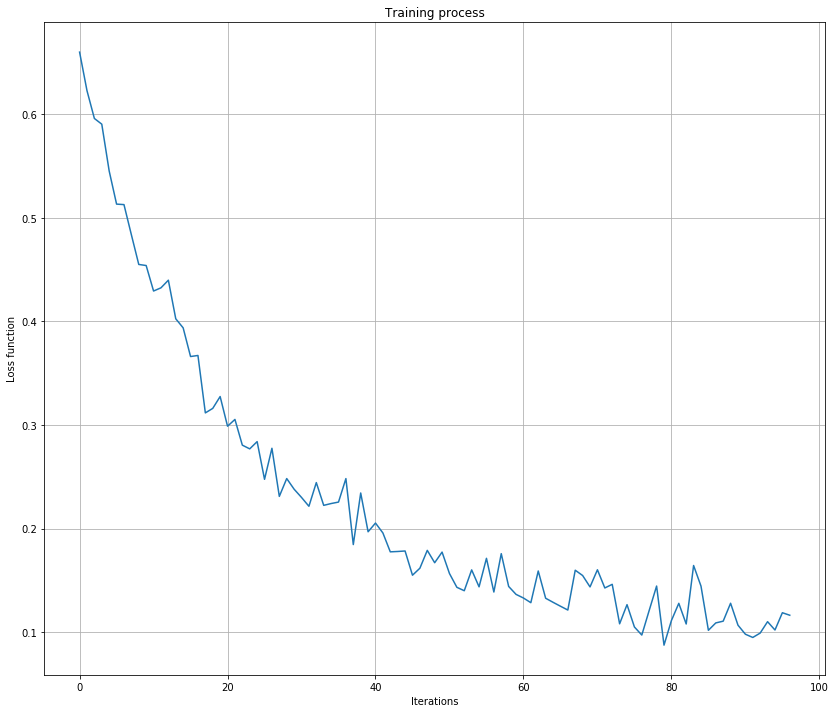

In [80]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Теперь мы можем что-то предсказать

In [81]:
for x, y in test_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()
    
    # чтобы не ходить по всему тестовому датасету, прекратим ходить после первой итерации
    break

In [82]:
x.shape

torch.Size([128, 784])

In [83]:
y.shape

torch.Size([128, 1])

In [84]:
# переходим в режим предсказания
# 
# позже в курсе мы разберем зачем конкретно это нужно
# некоторые детали:
# дропаут больше не зануляет часть значений, 
# батч норм больше не нормирует каждый батч, а использует накопленную статистику при обучении и тд
# 
model.eval()

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# этот контект позволяет не сохранять необходимую информацию для рассчета градиентов
# нам сейчас нужен только forward проход
# мы не собираемся обновлять веса
with torch.no_grad():

    pred = model(x)

In [86]:
pred.shape

torch.Size([128, 1])

In [87]:
# избавимся от единичной размерности
pred = pred.squeeze()
y = y.squeeze()

In [88]:
pred.shape

torch.Size([128])

In [89]:
# таким образом из торчовых тензоров мы можем сделать нумпаевские массивы
pred = pred.numpy()
y = y.numpy()

In [90]:
y

array([1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 1.], dtype=float32)

In [91]:
type(y)

numpy.ndarray

In [92]:
# бинаризируем наши предсказания
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

In [93]:
# посчитаем метрику на батче
accuracy_score(y, pred)

0.953125

In [94]:
# заново определим нашу модель и выучимся несколько эпох
# будут уже новые параметры
model = MLP(in_features=784, inner_features=256, out_features=1)

criterion = torch.nn.BCELoss()
# мы позже поговорим про этот оптимизационный алгоритм
# но вообще это тот же SGD, но с некоторыми хаками
optimizer = torch.optim.Adam(params=model.parameters())

# Типичный цикл обучения с кучей сохранений лоссов

In [95]:
epochs = 10
losses = []
# нужно для early stopping, то есть трекать лучший лосс на валидации
best_test_loss = 10.

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()
        
        optimizer.zero_grad()
        
        pred = model(x)
        
        loss = criterion(pred, y.float())
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():
            
            pred = model(x)
            
        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)
        
    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    
    test_preds = np.concatenate(test_preds)
    test_preds = test_preds.squeeze()
    test_targets = np.concatenate(test_targets).squeeze()
    
    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0
    
    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))
        
    # early stopping
    # то есть: если наша функция потерь на валидационном датасете стала расти, то прекращаем обучение
    # рост фунции потерь на валидационном датасете говорит о переобучении
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break    

Epoch 2:   7%|▋         | 896/12396 [00:00<00:02, 5670.09it/s, train_loss=0.0484]

Losses: train - 0.066, test = 0.053
Test: accuracy - 0.982


Epoch 3:   7%|▋         | 896/12396 [00:00<00:01, 5849.55it/s, train_loss=0.0251]

Losses: train - 0.026, test = 0.027
Test: accuracy - 0.989


Epoch 4:   8%|▊         | 1024/12396 [00:00<00:01, 5858.12it/s, train_loss=0.0147]

Losses: train - 0.015, test = 0.024
Test: accuracy - 0.992


Epoch 5:   7%|▋         | 896/12396 [00:00<00:01, 5810.79it/s, train_loss=0.011] 

Losses: train - 0.011, test = 0.022
Test: accuracy - 0.992


Epoch 5: 100%|██████████| 12396/12396 [00:02<00:00, 5580.47it/s, train_loss=0.00597]


Losses: train - 0.006, test = 0.022
Test: accuracy - 0.992
Early stopping


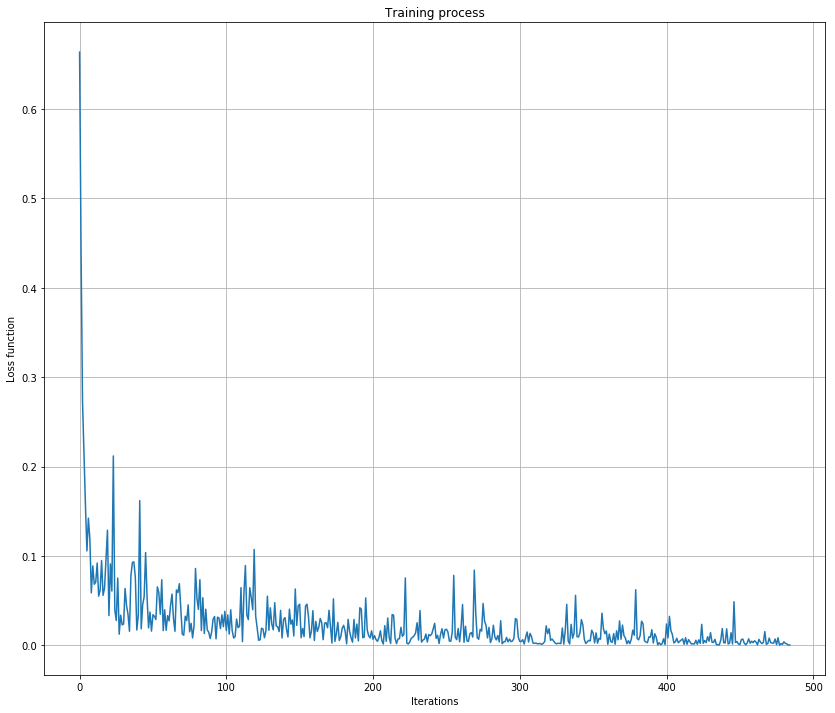

In [96]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# One more deeper
## Пойдем глубже раскрывать суть лего в глубоком обучении
Атомарной частью торча является ```torch.nn.Parameter``` - обучаемый вес.  
По сути это такой же тензор, но только мы говорим торчу, что мы хотим, чтобы торч сохранял градиент для этого веса, 
чтобы обновить его при градиентном шаге оптимизатора

```torch.nn.Parameter(data=None, requires_grad=True)```  
В дефолтном варианте для тензора мы не требуем сохранять градиент, но можем потребовать и тогда наш тензор станет обучаемым весом  
```tensor(data, dtype=None, device=None, requires_grad=False)```

In [97]:
parampampam = torch.nn.Parameter(torch.rand(50))
parampampam

Parameter containing:
tensor([0.6765, 0.6291, 0.8897, 0.8332, 0.4532, 0.6474, 0.1170, 0.4848, 0.7145,
        0.5726, 0.8602, 0.5012, 0.3940, 0.4693, 0.5787, 0.6087, 0.9681, 0.9121,
        0.1678, 0.4643, 0.5722, 0.0650, 0.8282, 0.9466, 0.0076, 0.4634, 0.6401,
        0.3052, 0.4491, 0.9428, 0.5724, 0.0652, 0.0134, 0.3274, 0.0229, 0.0876,
        0.7551, 0.5834, 0.9055, 0.2912, 0.1975, 0.5561, 0.5369, 0.5984, 0.1102,
        0.0741, 0.2823, 0.2999, 0.1386, 0.8499], requires_grad=True)

In [98]:
x = torch.rand(32, 50)

In [99]:
result = parampampam - x

In [100]:
result

tensor([[ 0.4822, -0.2324,  0.4969,  ..., -0.6747,  0.0034,  0.1174],
        [ 0.5627,  0.4203,  0.6759,  ..., -0.6563,  0.0878,  0.0150],
        [ 0.6324,  0.4176, -0.0564,  ..., -0.3579, -0.1785,  0.7980],
        ...,
        [ 0.2495,  0.2776,  0.5789,  ..., -0.6311, -0.4741,  0.4814],
        [ 0.3657, -0.3540, -0.0314,  ..., -0.3992, -0.1963,  0.6425],
        [ 0.6192,  0.3689,  0.4614,  ...,  0.0827,  0.0238, -0.0178]],
       grad_fn=<SubBackward0>)

### Можно заметить, что у тензора result теперь есть атрибут grad_fn
Это функция, по которой нужно рассчитывать градиент  
И это говорит о том, что теперь у нас есть граф вычислений

In [101]:
result.grad_fn

### И мы можем продолжать наш граф

In [102]:
result_end = torch.sigmoid(result)

In [103]:
result_end

tensor([[0.6183, 0.4421, 0.6217,  ..., 0.3374, 0.5009, 0.5293],
        [0.6371, 0.6035, 0.6628,  ..., 0.3416, 0.5219, 0.5037],
        [0.6530, 0.6029, 0.4859,  ..., 0.4115, 0.4555, 0.6896],
        ...,
        [0.5620, 0.5690, 0.6408,  ..., 0.3472, 0.3837, 0.6181],
        [0.5904, 0.4124, 0.4921,  ..., 0.4015, 0.4511, 0.6553],
        [0.6500, 0.5912, 0.6133,  ..., 0.5207, 0.5059, 0.4955]],
       grad_fn=<SigmoidBackward>)

### Для примера того, когда у нас граф не строится
Когда нам нечего оптимизировать!

In [104]:
z = torch.rand(50)

In [105]:
result_2 = torch.sigmoid(z - x)

In [106]:
result_2

tensor([[0.4837, 0.5115, 0.5762,  ..., 0.2829, 0.5518, 0.5105],
        [0.5038, 0.6679, 0.6192,  ..., 0.2866, 0.5726, 0.4849],
        [0.5212, 0.6673, 0.4387,  ..., 0.3513, 0.5065, 0.6732],
        ...,
        [0.4261, 0.6355, 0.5961,  ..., 0.2918, 0.4330, 0.6001],
        [0.4547, 0.4811, 0.4449,  ..., 0.3419, 0.5021, 0.6381],
        [0.5179, 0.6564, 0.5675,  ..., 0.4569, 0.5568, 0.4767]])

In [107]:
# нет ссылки на функцию, по которой можем рассчитать градиент
print(result_2.grad_fn)

None


# Обучаемые веса
## Теперь мы знаем, что можем сами задавать веса
Так давайте сделаем свой класс для линейного преобразования

In [108]:
class MyLinear(torch.nn.Module):
    
    def __init__(self, in_features, out_features):
        
        super().__init__()
        
        # задаем матрицу весов и смещение
        self.weight = torch.nn.Parameter(torch.rand(in_features, out_features) * 0.01)
        self.bias = torch.nn.Parameter(torch.zeros(out_features))
        
    def forward(self, x):
        
        return torch.matmul(x, self.weight) + self.bias

## Вот таким образом можно написать свои функции и то, как их дифференцировать
На практике встречается супер редко

In [109]:
class MyReLU(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x):

        ctx.save_for_backward(x)
        
        return x.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):

        x, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[x < 0] = 0
        
        return grad_input

In [110]:
class MLP(torch.nn.Module):
    
    def __init__(self, in_features, inner_features, out_features):
        
        super().__init__()
        
        # слои определяются также как обычно
        self.linear_1 = MyLinear(in_features=in_features, out_features=inner_features)
        # обратите внимание как определяется своя функция
        self.non_linear = MyReLU.apply
        self.linear_2 = MyLinear(in_features=inner_features, out_features=out_features)
        # еще один момент:
        # мы сознательно не определяем сигмоиду
        # 
        # Почему?
        # В торче для NLL и Binary Cross Entropy 
        # есть более оптимальные слои, которые используют некоторые оптимизационные трюки
        # 
        
    def forward(self, x):
        
        x = self.linear_1(x)
        x = self.non_linear(x)
        x = self.linear_2(x)
        
        return x

In [111]:
model = MLP(784, 256, 1)

In [112]:
model

MLP(
  (linear_1): MyLinear()
  (linear_2): MyLinear()
)

In [113]:
# вот оптимизация для BCE 
# эта функция потерь объединяет в себе сигмоиду и BCE
# и решает задачу более эффективно

# 
# Для NLLLoss есть это CrossEntropy: https://pytorch.org/docs/stable/nn.html#crossentropyloss
# 
# 
criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params=model.parameters())

In [114]:
# определим функцию для сигмоиды, чтобы использовать при тестировании
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

In [115]:
epochs = 10
losses = []
best_test_loss = 10.

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()
        
        optimizer.zero_grad()
        
        pred = model(x)
        
        loss = criterion(pred, y.float())
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():
            
            pred = model(x)
            
        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), np.mean(test_losses)))
    
    test_preds = np.concatenate(test_preds)
    # Применяем сигмоиду
    test_preds = sigmoid(test_preds.squeeze())
    test_targets = np.concatenate(test_targets).squeeze()
    
    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0
    
    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))
        
    if np.mean(test_losses) < best_test_loss:
        best_test_loss = np.mean(test_losses)
    else:
        print('Early stopping')
        break    

Epoch 2:   6%|▌         | 768/12396 [00:00<00:02, 5117.26it/s, train_loss=0.165]

Losses: train - 0.196, test = 0.076
Test: accuracy - 0.976


Epoch 3:   6%|▌         | 768/12396 [00:00<00:02, 4903.50it/s, train_loss=0.0411]

Losses: train - 0.042, test = 0.051
Test: accuracy - 0.984


Epoch 4:   6%|▌         | 768/12396 [00:00<00:02, 5105.40it/s, train_loss=0.0328]

Losses: train - 0.033, test = 0.039
Test: accuracy - 0.988


Epoch 5:   6%|▌         | 768/12396 [00:00<00:02, 4928.67it/s, train_loss=0.0253]

Losses: train - 0.024, test = 0.035
Test: accuracy - 0.990


Epoch 6:   6%|▌         | 768/12396 [00:00<00:02, 5039.42it/s, train_loss=0.017] 

Losses: train - 0.018, test = 0.029
Test: accuracy - 0.991


Epoch 6: 100%|██████████| 12396/12396 [00:02<00:00, 4911.62it/s, train_loss=0.0156]


Losses: train - 0.015, test = 0.034
Test: accuracy - 0.990
Early stopping
